<a href="https://colab.research.google.com/github/yardsale8/probability_simulations_in_R/blob/main/2_6_plotting_estimated_distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
library(tidyverse)
library(devtools)
install_github('yardsale8/purrrfect', force = TRUE)
library(purrrfect)

# Plotting and Summarizing Simulated Distributions

In this notebook, we will look as stacking the results of simple and parametric simulations to allow for tabulating and summarizing the resulting distribution.

## Stacking, plotting, and summarizing a simple simulation of one or more categorical outcomes

First, we will look at working with a simple categorical

## Stacking Outcomes and Plotting Parametric Simulations

The final option, not covered above, is to stack the outcomes in a simple, atomic column.  This approach is used primarily when plotting the distributions for each parameter or combination of parameters and has the advantage to this approach is simplier mutates (rarely need to map), but at the cost of spreading the related trials across multiple rows--requiring an extra grouped aggregation to accomplish other common task (e.g., estimating probabilities, expected values, quantiles, etc.).

### The "shape" of a stacked parametric simulation.

1. Set up the parameter space using a `tribble`.
2. Unnest the parameter(s) of interest.
3. Add trials to convert the parameter space into an experimental notebook.
4. Use `map` or `pmap` to generate outcomes using the parameter column(s) as input.
5. Proceed as usual (estimate probabilities, expected values, etc.).

### Setting up the parameter space

The `tribble` functions can create the nested parameter space, with

1. The names of the column, starting with `~`, on the first line, and
2. Vectors or lists of parameters on the second line.

Note that you need to line up the names and parameter vectors, respectively (first with first, second with second, etc.). The output is a `tibble` with one row, containing a list column for each parameter.



In [2]:
parameters(~n,
           seq(5,15,5))

n
<dbl>
5
10
15


### Adding trials

Next, we need to replicate each parameter over a number of trials, which is accomplished using `add_trials`

In [3]:
num.trials <- 5
(parameters(~n,
            seq(5,15,5))
 %>% add_trials(num.trials)
 )

n,.trial
<dbl>,<dbl>
5,1
5,2
5,3
5,4
5,5
10,1
10,2
10,3
10,4


#### Generating outcomes with `map`

To use map, we need to

1. Map onto the parameter column, and
2. Write a function that takes this parameter as input.

As alway, select the version of `map` that results in an atomic column type.  In this case, we will use `map_int`, as `rbinom` generates intergers.

In [4]:
num.trials <- 5
p <- 0.5
(parameters(~n,
            seq(5,15,5))
 %>% add_trials(num.trials)
 %>% mutate(num.successes = map_int(n, \(n) rbinom(1, n, p)))
 )

n,.trial,num.successes
<dbl>,<dbl>,<int>
5,1,1
5,2,4
5,3,1
5,4,3
5,5,4
10,1,4
10,2,4
10,3,6
10,4,5


### Bump trials and plot with `ggplot`

Finally, we can complete the task, which involves grouping and aggregating to get estimates of the long-run mean for each sample size.

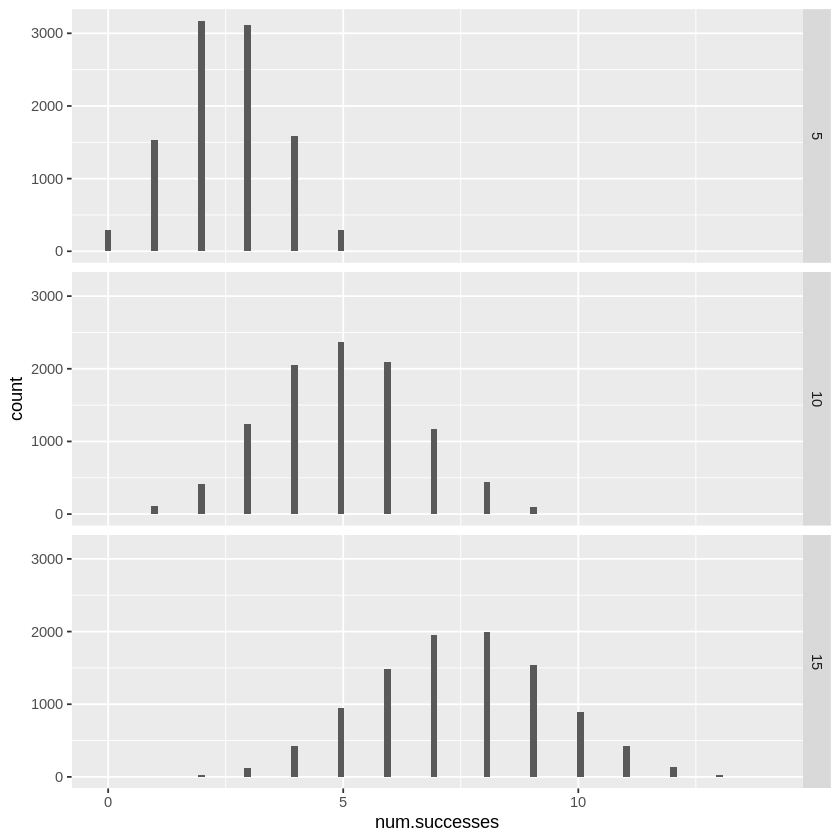

In [5]:
# Test on small number of trials
num.trials <- 10000
p <- 0.5
(parameters(~n,
            seq(5,15,5))
 %>% add_trials(num.trials)
 %>% mutate(num.successes = map_int(n, \(n) rbinom(1, n, p)))
 ) -> trials

ggplot(trials) +
   geom_histogram(aes(x = num.successes), bins = 100) +
   facet_grid(rows = vars(n))

### Example - Plotting a 2 parameter problem

Now suppose we want to compare distributions when changing both $n$ and $p$.

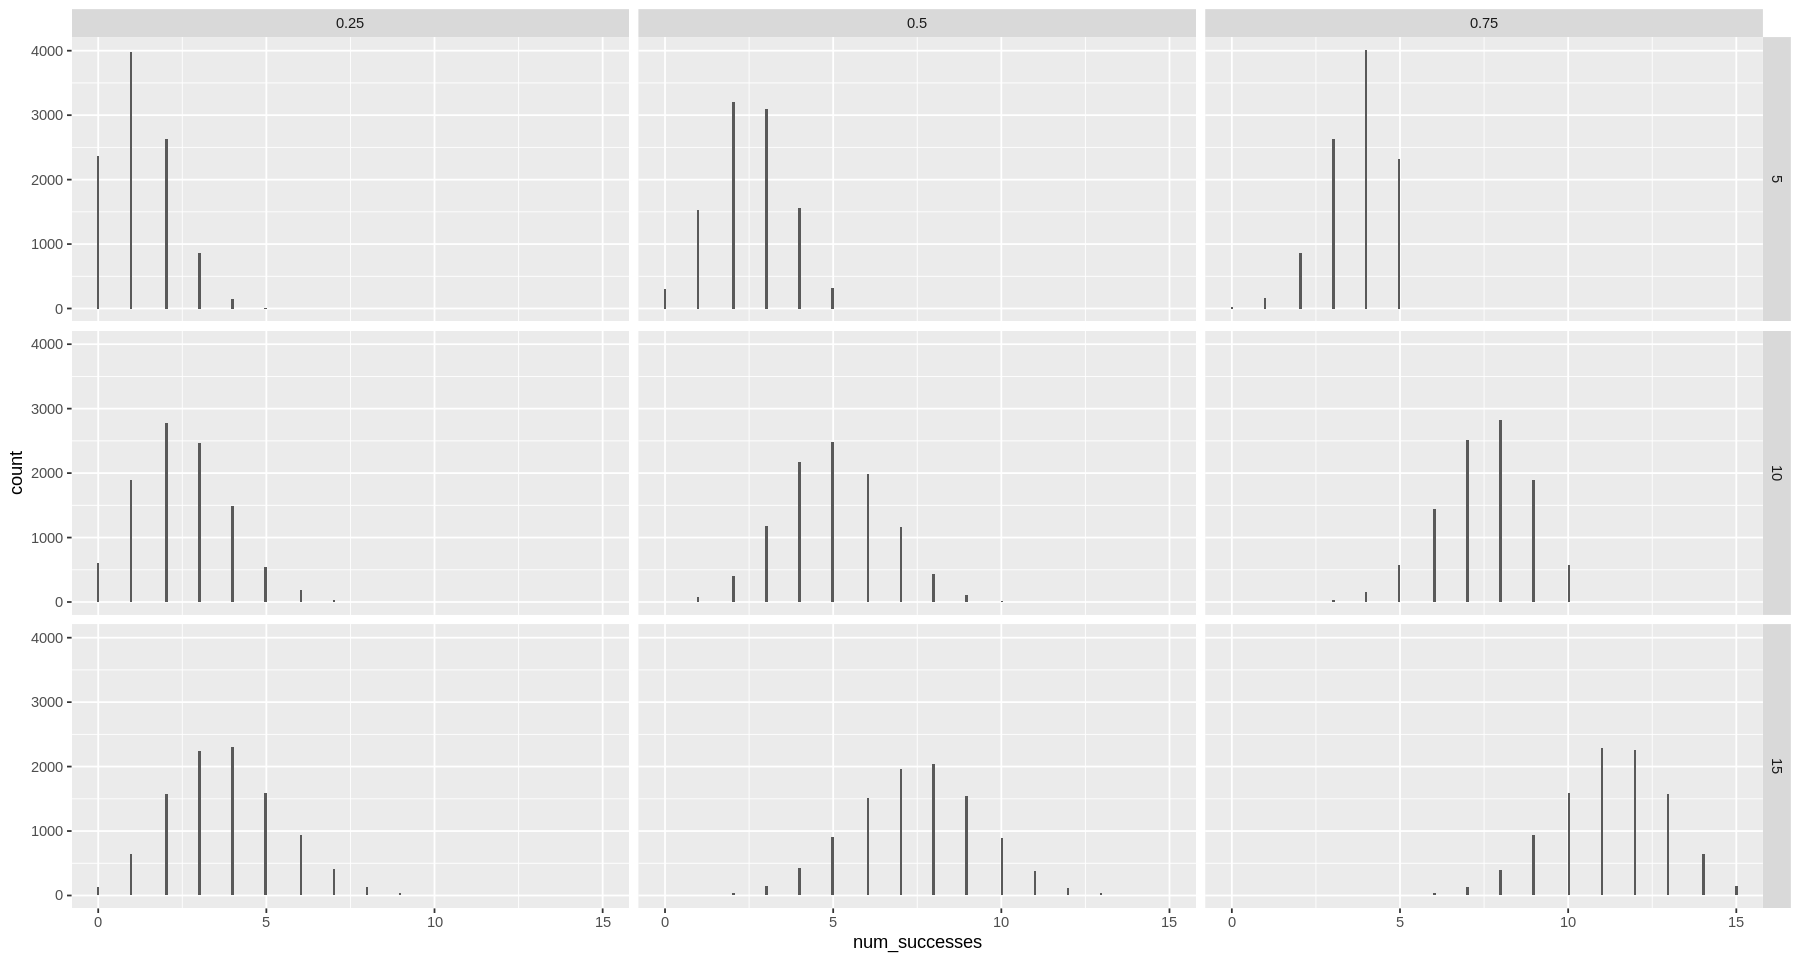

In [6]:
num.trials <- 10000
(parameters(~n,         ~p,
            c(5,10,15), c(0.25, 0.5, 0.75))
 %>% add_trials(num.trials)
 %>% mutate(num_successes = map2_int(n, p, \(n, p) rbinom(1, n, p)))
 ) -> trials

# Make plots wider (Colab only)
options(repr.plot.width=15, repr.plot.height=8)

ggplot(trials) +
   geom_histogram(aes(x = num_successes), bins = 200) +
   facet_grid(rows = vars(n), cols = vars(p))

## Plotting the CDF

Next, we will look at plotting the cumulative distribution function (CDF).  First, let's review

### Review - Empirical and Theoretical CDFs

Recall that the CDF of a random variable $X$ is the function $F$ such that $F(x) = P(X \le x)$ for all $x\in\mathbb{R}$.  We will be refering to this functions at the **theoretical CDF**.  The **empirical CDF** is the sample estimate of said function, and is constructed by computing the fraction of the data at or below is observed value.

### Computing empirical and theoretical CDFs in R

We can use the following functions to compute or estimate the CDF.

1. The window function `cume_dist` is applied to the outcome column to estimate the CDF of that point using the sample.  Note that in parametric simulations, we will need to group by the parameter(s) using the `.by` argument of `mutate`
2. We can compute the theoretical CDF of the outcomes by mapping the parameters + observed value onto respective R "p" function, such at `pbinom` or `pnorm`.

### Example - Plotting the empiritcal and theortical CDFs for many values of $n$

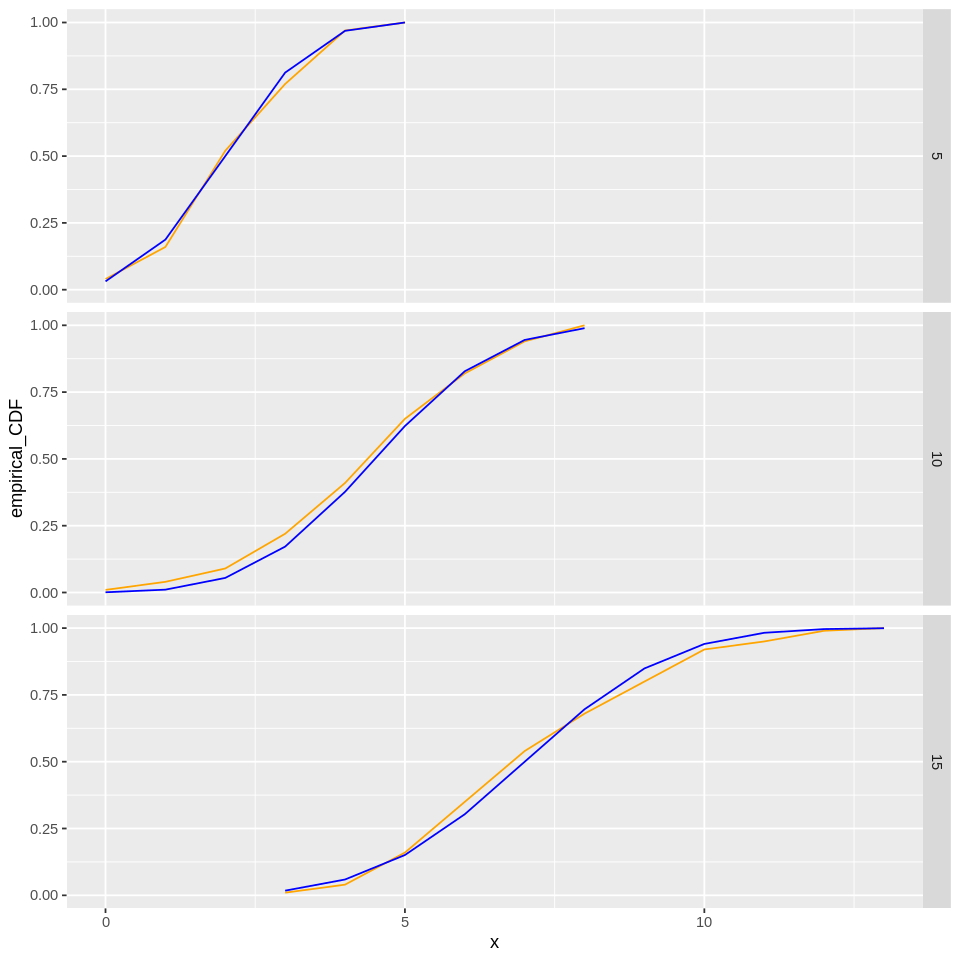

In [7]:
num.trials <- 100
p <- 0.5
(tribble(~n,
        seq(5,15,5))
 %>% unnest_longer(n)
 %>% add_trials(num.trials)
 %>% mutate(x = map_int(n, \(n) rbinom(1, n, p)))
 %>% mutate(empirical_CDF = cume_dist(x), .by = n)
 %>% mutate(theoretical_CDF = map2_dbl(x, n, \(x,n) pbinom(x, n, p)))
 ) -> one_param_CDF_data

# Make plots wider (Colab only)
options(repr.plot.width=8, repr.plot.height=8)

# CDF_data
 ggplot(data = one_param_CDF_data) +
   geom_line(aes(x = x, y = empirical_CDF), color = "orange") +
   geom_line(aes(x = x, y = theoretical_CDF), color = "blue") +
   facet_grid(rows = vars(n))


### Example - Plotting the empiritcal and theortical CDFs for many values of $n$ and $p$

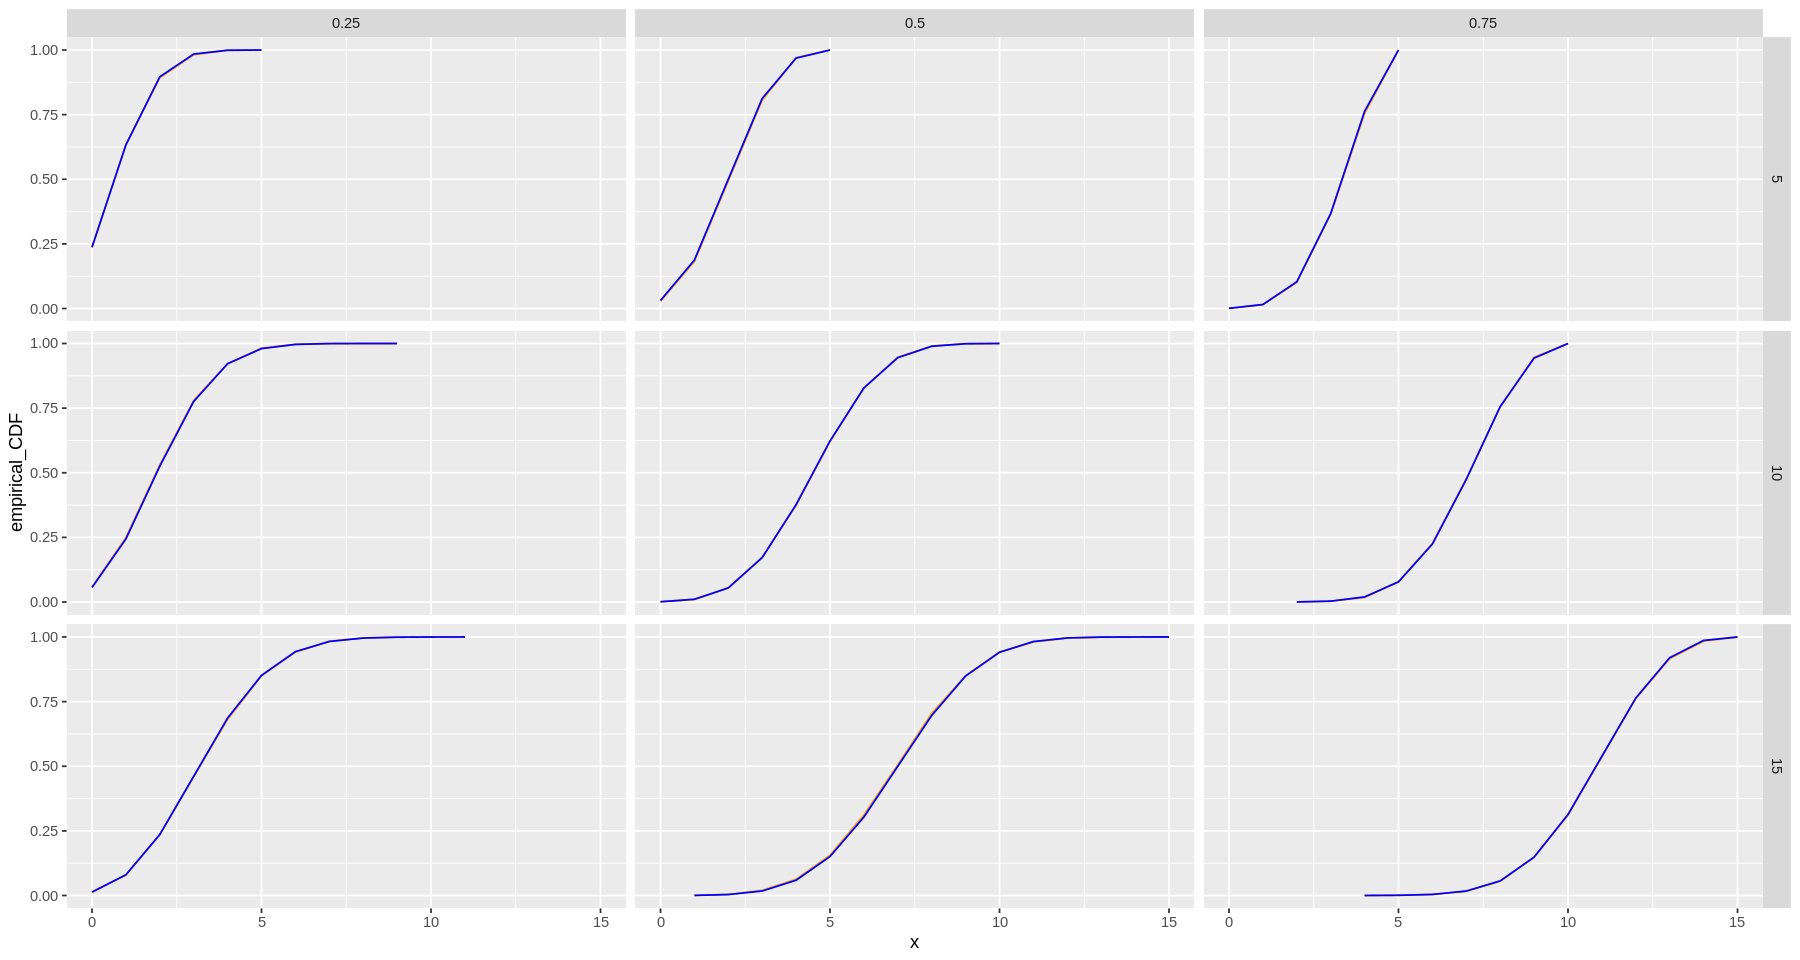

In [9]:
num.trials <- 10000
(tribble(~n,         ~p,
         c(5,10,15), c(0.25, 0.5, 0.75))
 %>% unnest_longer(n)
 %>% unnest_longer(p)
 %>% add_trials(num.trials)
 %>% mutate(x = map2_int(n, p, \(n, p) rbinom(1, n, p)))
 %>% mutate(empirical_CDF = cume_dist(x), .by = c(n, p))
 %>% mutate(theoretical_CDF = pmap_dbl(list(x, n, p), pbinom))
 ) -> two_param_CDF_data

# Make plots wider (Colab only)
options(repr.plot.width=15, repr.plot.height=8)

# prob_plot_data
 ggplot(data = two_param_CDF_data) +
   geom_line(aes(x = x, y = empirical_CDF), color = "orange") +
   geom_line(aes(x = x, y = theoretical_CDF), color = "blue") +
   facet_grid(rows = vars(n), cols = vars(p))

## Creating a p-p plot

While the plots in the last example illustrated the similarity between the empirical and theoretical CDFs, the standard way of making this comparison is with a [p-p plot ](https://en.wikipedia.org/wiki/P%E2%80%93P_plot).  This is accomplished by making a scatterplot of the estimated and theoretical values of the CDf.  For convenience, we will also add the $y=x$ reference line (see below).

**Interpretation.** If the simulated data matches the theoretical distribution, the pointing in the p-p plot will be nearly identical and close to the reference.  On the other hand, if the observed data deviate from the theoretical distribution, the points will differ and be distant from the reference line.

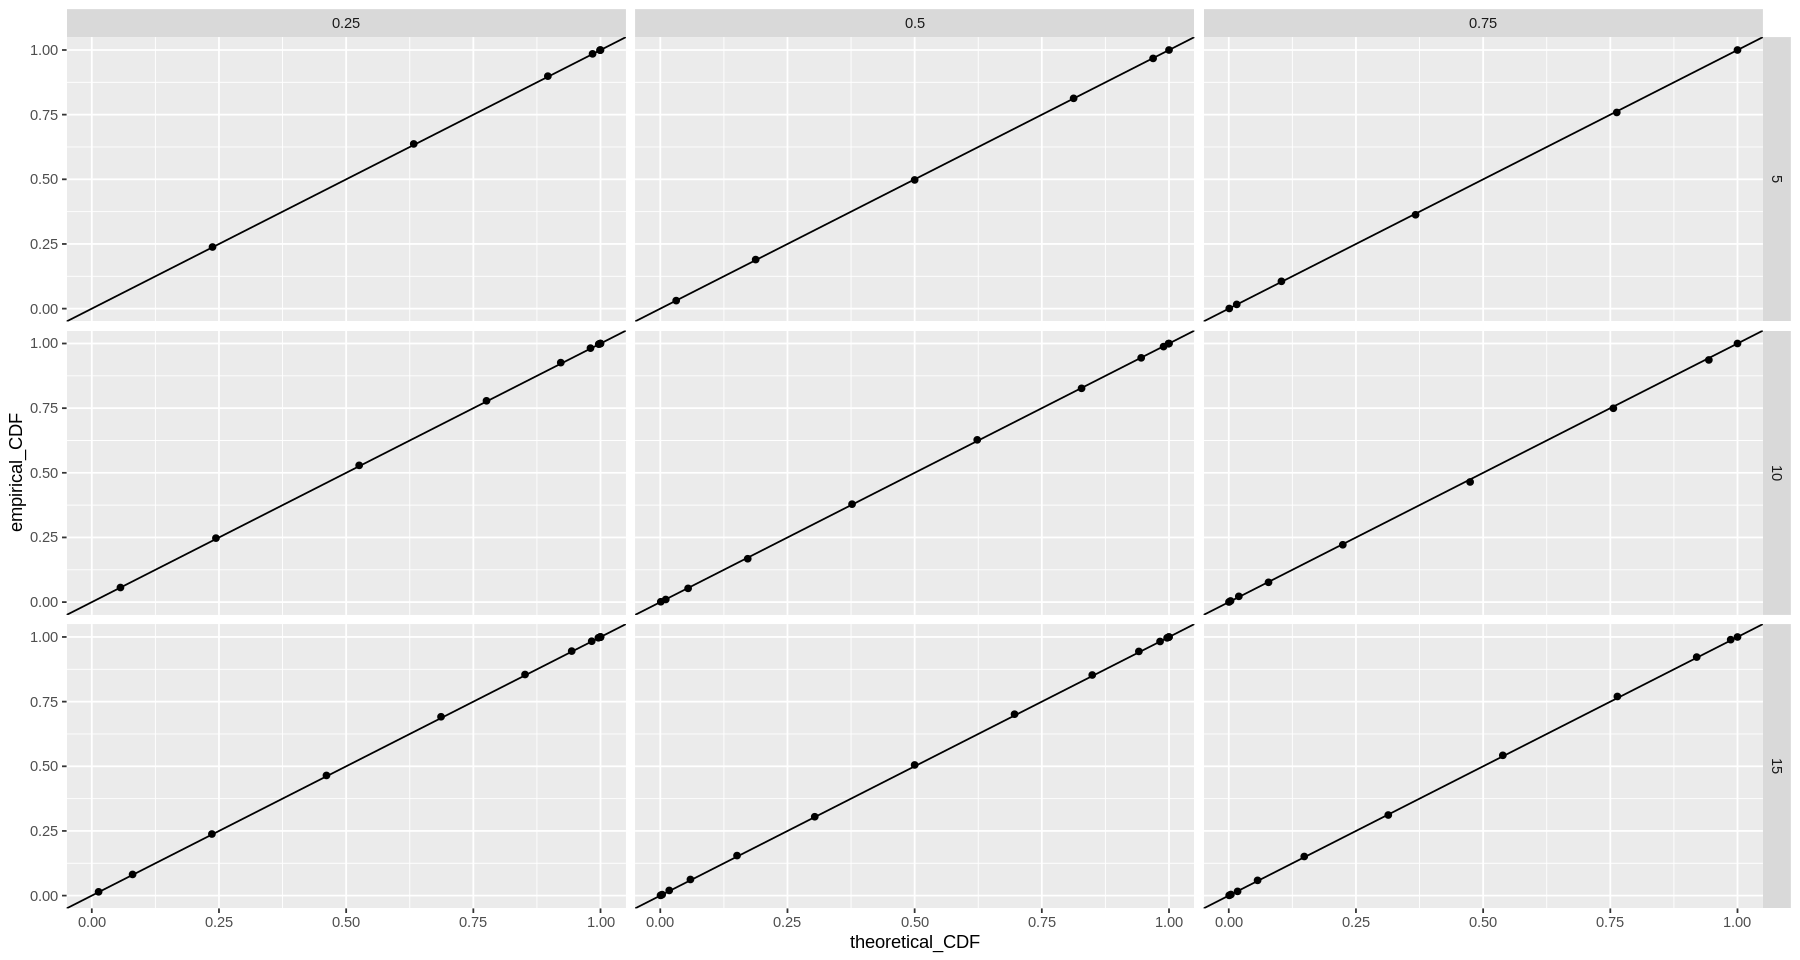

In [95]:
   geom_abline(aes(slope = 1, intercept = 0)) +
   geom_point(aes(x = theoretical_CDF, y = empirical_CDF)) +
   facet_grid(rows = vars(n), cols = vars(p))